In [69]:
import os
import sys
import seaborn as sns
import missingno as msno

sys.path.append("code/.")

import IPython
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

from IPython.display import Image

In [70]:
# Changing global matplotlib settings for confusion matrix.
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [71]:
train = pd.read_csv("../data/train.csv", encoding="latin-1")
labels = pd.read_csv("../data/trainlabel.csv", encoding="latin-1")
df = pd.concat([train,labels])
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,NaN,NaN
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,NaN,NaN
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,NaN,NaN


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41546 entries, 0 to 14838
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                41546 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [ ]:
num_cols = df.select_dtypes(exclude=['object'])
str_cols = df.select_dtypes(include=['object'])

In [73]:
mis_percent = ((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)
mis_val = df.isna().sum()
mis_val_table = pd.concat([mis_val, mis_percent], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'count', 1 : 'percent'})
mis_val_table_ren_columns = mis_val_table_ren_columns[
       mis_val_table_ren_columns.iloc[:,:] != 0].sort_values(
        'percent', ascending=False).round(1)
mis_val_table_ren_columns

,count,percent
employment_occupation,28309.0,68.1
employment_industry,28169.0,67.8
health_insurance,27113.0,65.3
seasonal_vaccine,26707.0,64.3
h1n1_vaccine,26707.0,64.3
income_poverty,19262.0,46.4
doctor_recc_h1n1,16999.0,40.9
doctor_recc_seasonal,16999.0,40.9
rent_or_own,16881.0,40.6
employment_status,16302.0,39.2


<AxesSubplot:>

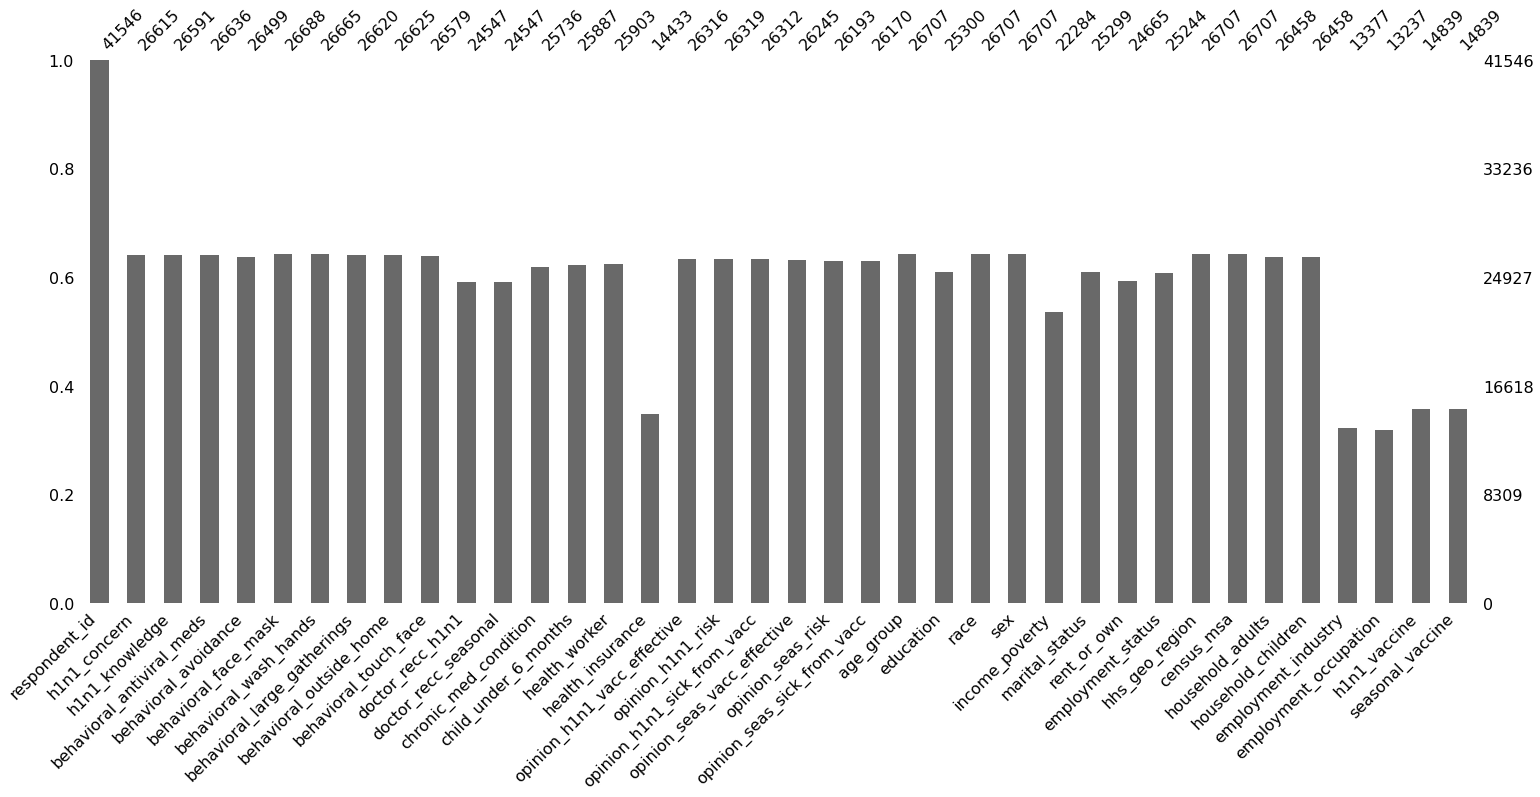

In [74]:
msno.bar(df)

<AxesSubplot:>

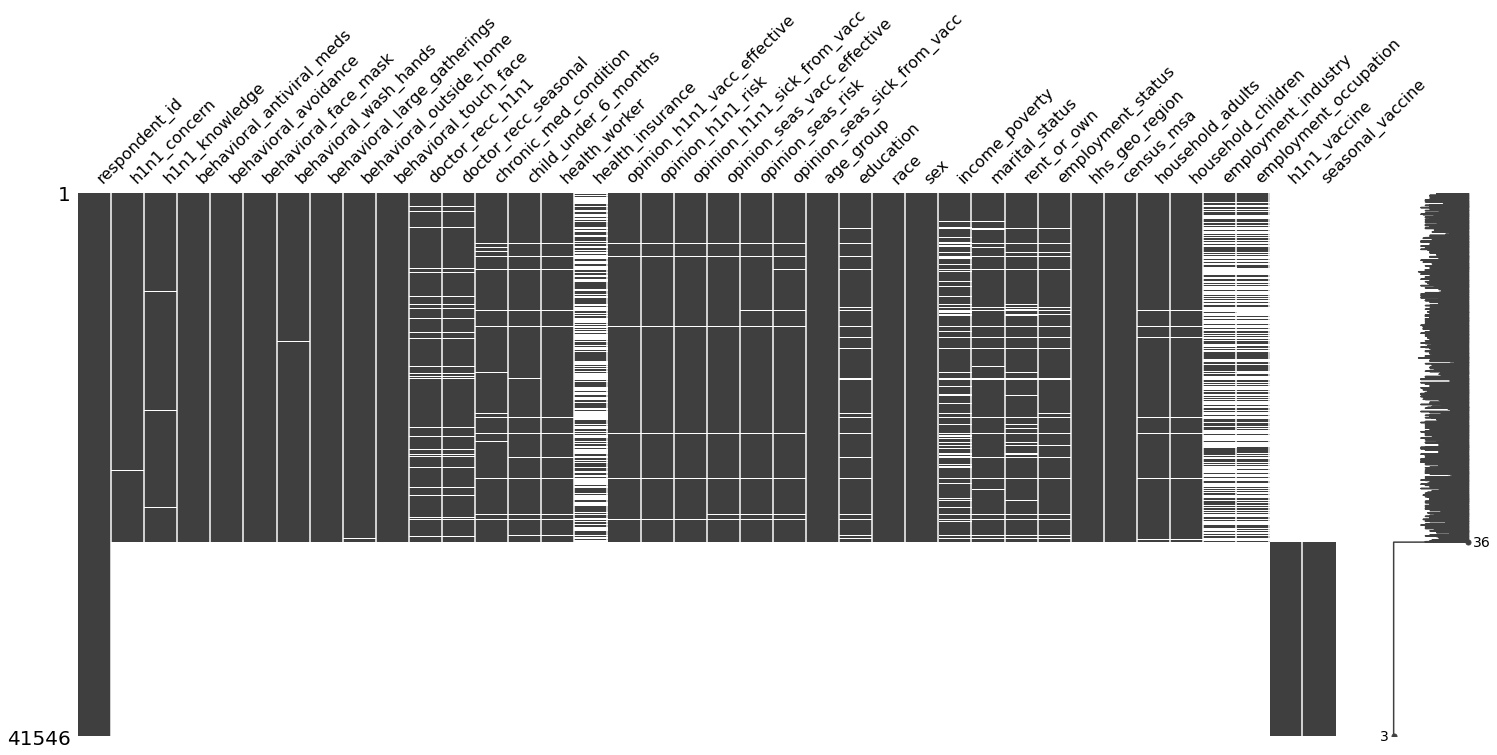

In [75]:
msno.matrix(df)


<AxesSubplot:>

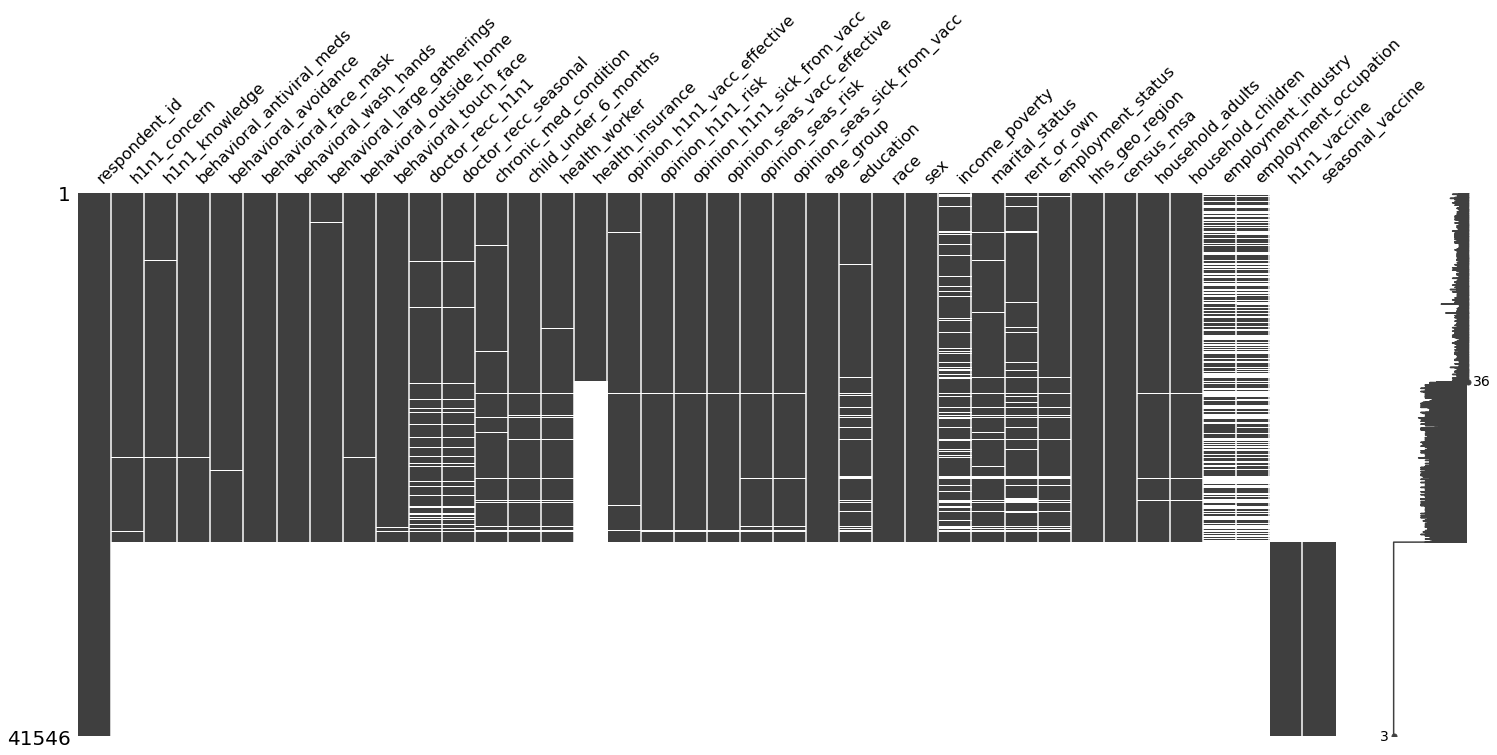

In [76]:
sorted = df.sort_values('health_insurance')
msno.matrix(sorted)

<AxesSubplot:>

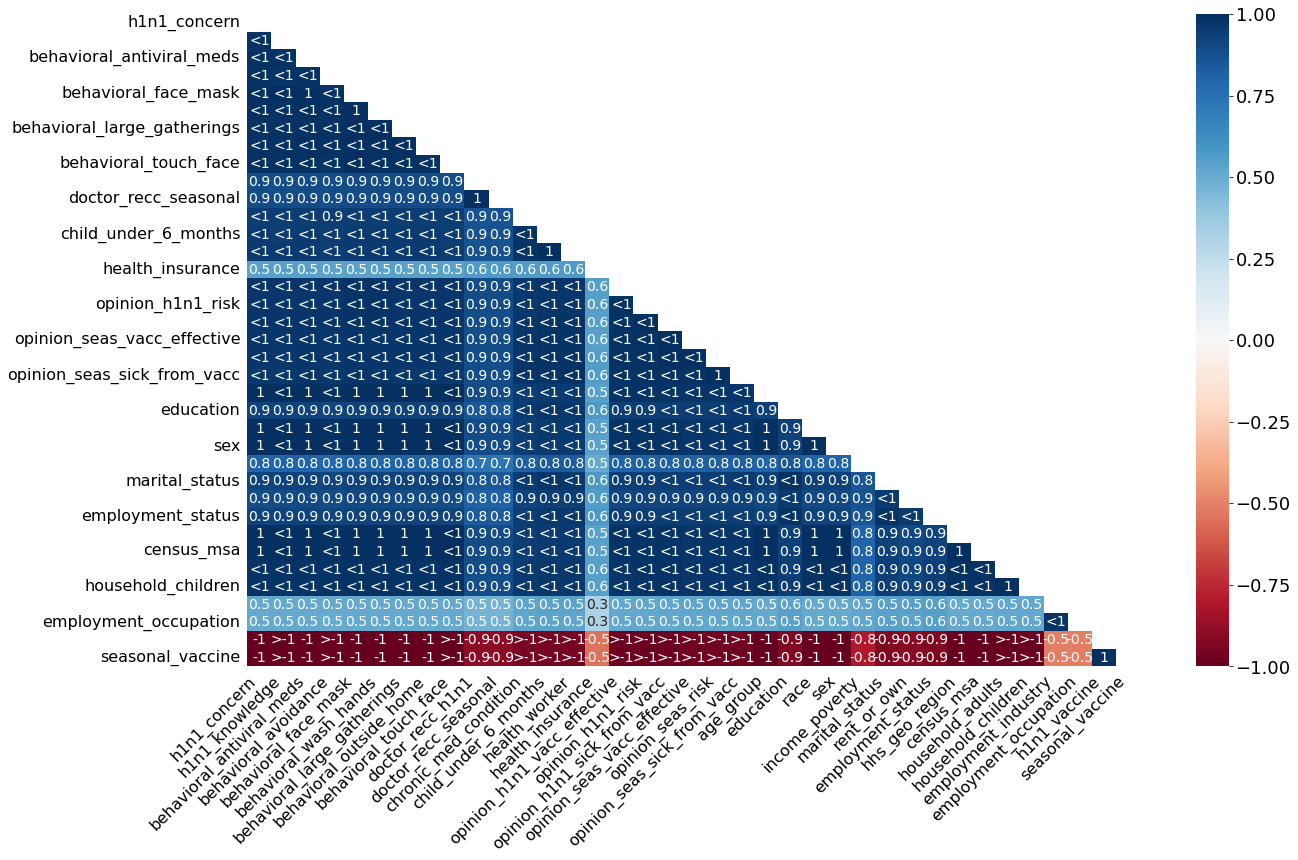

In [77]:
msno.heatmap(df)

<AxesSubplot:>

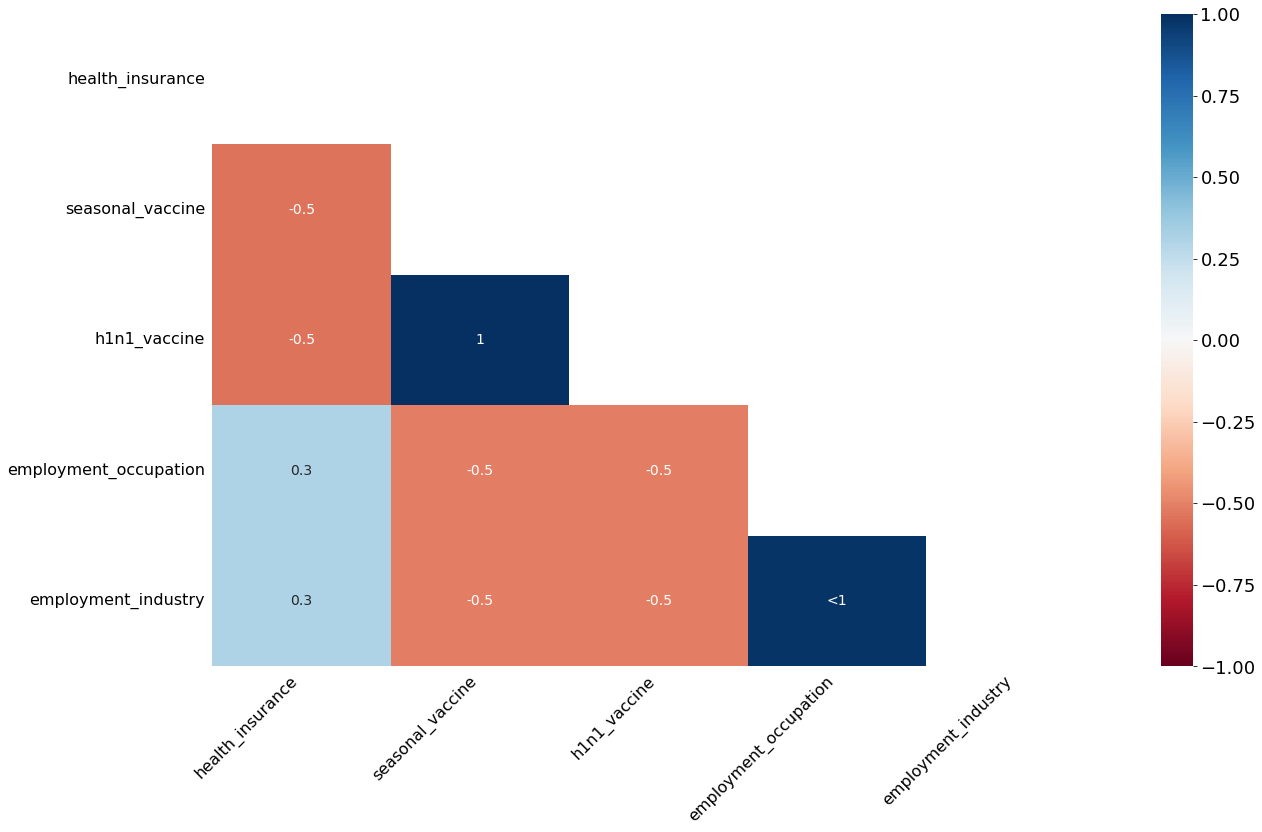

In [78]:
msno.heatmap(df[['health_insurance', 'seasonal_vaccine', 'h1n1_vaccine', 'employment_occupation', 'employment_industry']])

## Multicolinearity : Heatmap and VIF

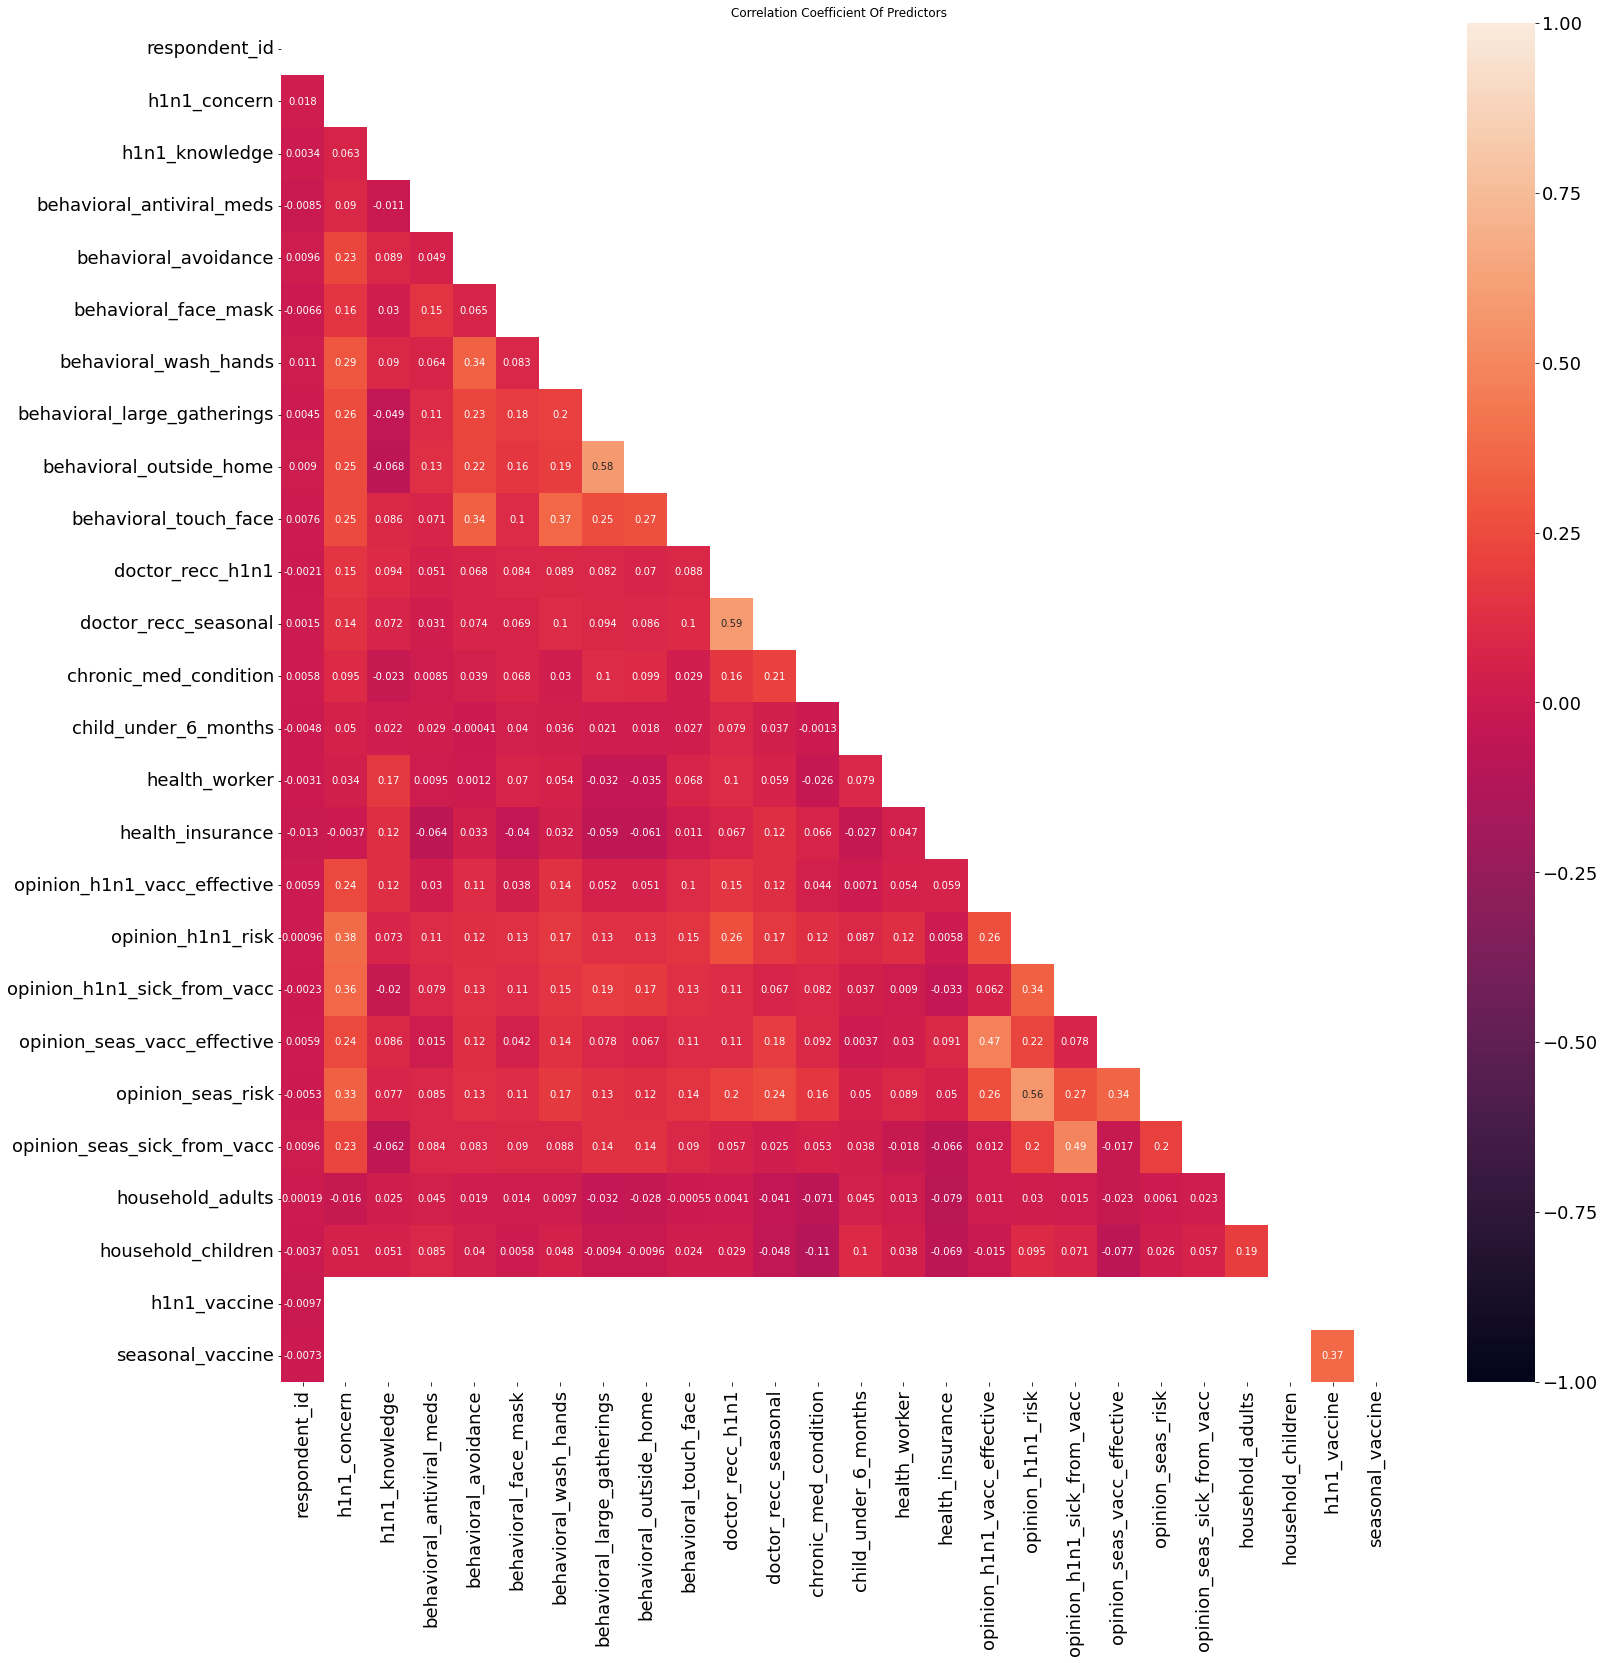

In [96]:
# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(num_cols.corr(), dtype=bool))
plt.figure(figsize=(25,25))
# generate heatmap
sns.heatmap(num_cols.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

In [106]:
# replace nans as -9999
num_cols=num_cols.fillna(-9999)
num_cols

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,3.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0,-9999.0,-9999.0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,5.0,4.0,4.0,4.0,2.0,4.0,0.0,0.0,-9999.0,-9999.0
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,1.0,4.0,1.0,2.0,2.0,0.0,-9999.0,-9999.0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,3.0,3.0,5.0,5.0,4.0,1.0,0.0,0.0,-9999.0,-9999.0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,3.0,3.0,2.0,3.0,1.0,4.0,1.0,0.0,-9999.0,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14834,14834,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.0,1.0
14835,14835,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.0,1.0
14836,14836,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.0,0.0
14837,14837,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.0,1.0


In [108]:
# compute the vif for all given features
def compute_vif(considered_features):
    
    X = num_cols[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [110]:
considered_features =list(num_cols.columns)
compute_vif(considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
10,doctor_recc_h1n1,2.532296e+08
11,doctor_recc_seasonal,2.532292e+08
24,h1n1_vaccine,2.441708e+08
25,seasonal_vaccine,2.441705e+08
22,household_adults,3.136228e+07
23,household_children,3.136165e+07
5,behavioral_face_mask,5.093821e+02
6,behavioral_wash_hands,2.305308e+02
14,health_worker,2.285919e+02
13,child_under_6_months,2.137289e+02


In [127]:
drop = ['doctor_recc_h1n1', 'household_adults', 'behavioral_antiviral_meds','h1n1_vaccine', 'seasonal_vaccine']
#consider = filter(lambda x: x in considered_features, drop )
consider = [x for x in considered_features if x not in drop]

In [131]:
compute_vif(consider).sort_values('VIF', ascending=False)

/var/folders/9k/93y5mwqx7vv2w2hhhthftg980000gn/T/ipykernel_4891/508733631.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
4,behavioral_face_mask,302.051524
12,health_worker,228.572901
11,child_under_6_months,213.620034
5,behavioral_wash_hands,194.635749
16,opinion_h1n1_sick_from_vacc,177.803046
18,opinion_seas_risk,157.714674
19,opinion_seas_sick_from_vacc,151.502445
17,opinion_seas_vacc_effective,135.990346
15,opinion_h1n1_risk,127.468646
7,behavioral_outside_home,117.187872


### Drop All missing Values

In [60]:
df_o.describe(include="all")

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
count,41546.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,24665,25244,26707,26707,26458.000000,26458.000000,13377,13237,14839.000000,14839.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,3,10,3,NaN,NaN,21,23,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Own,Employed,lzgpxyit,"MSA, Not Principle City",NaN,NaN,fcxhlnwr,xtkaffoo,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18736,13560,4297,11645,NaN,NaN,2468,1778,NaN,NaN
mean,11233.551052,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,NaN,NaN,NaN,NaN,0.886499,0.534583,NaN,NaN,0.212278,0.466339
std,7269.724979,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,NaN,NaN,NaN,NaN,0.753422,0.928173,NaN,NaN,0.408935,0.498882
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000
25%,5193.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000
50%,10386.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,0.000000,0.000000
75%,16319.750000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,0.000000,1.000000
